In [10]:
import numpy as np

import torch
import torch.nn as nn

import jax.numpy as jnp

import matplotlib.pyplot as plt

from kernel_sca_inducing_points import *
from kernels import *
from utils import *

In [4]:
def DDM(mu, sequence_length, sigma=0.5, dt=1, seed=None):
    if seed is not None:
        np.random.seed(seed) 
    num_trajectories = len(mu)
    num_steps = int(sequence_length / dt)
    x = np.zeros((num_trajectories, num_steps + 1))

    for i in range(num_trajectories):
        for t in range(num_steps):
            x[i, t + 1] = x[i, t] + mu[i] * dt + sigma * np.sqrt(dt) * np.random.normal()
    
    p = np.sign(mu)
    x = x[:, :, None]
    return torch.tensor(x, dtype=torch.float32), torch.tensor(p, dtype=torch.long)

def mse_loss(z, p):
    return ((z - p)**2).mean()
    
class DriftDiffusionRNN(torch.nn.Module):
    def __init__(self, hidden_size, input_size, output_size):
        super(DriftDiffusionRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = torch.nn.RNNCell(input_size, hidden_size, nonlinearity='tanh')
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_i = torch.zeros(x.shape[0], self.hidden_size)
        z = torch.zeros(x.shape[0], 1)
        mask = torch.ones(x.shape[0], 1, dtype=torch.bool)  #array of True 
        ls_h_i = []
        for i in range(x.shape[1]):
            h_i = self.rnn(x[:, i], h_i)
            output = self.fc(h_i)
            z += output * mask 

            mask = torch.logical_and(mask, z.abs() < 1)    #False if threshold is reached

            ls_h_i.append(h_i)
            if mask.sum() == 0:
                break

        return z, ls_h_i

def train_model(model, optimizer, mu, iterations=10, sequence_length=50, save_path = 'model.pth'):
    model.train()
    ls_loss = []
    for iter in range(iterations):
        x, p = DDM(mu, sequence_length)
        optimizer.zero_grad()
        z, ls_h_i = model(x)  
        loss = mse_loss(z, p)
        loss.backward()
        optimizer.step()

        ls_loss.append(loss.item())
        print(f'Iteration [{iter+1}/{iterations}], Loss: {loss.item():.4f}')
    #torch.save(model.state_dict(), save_path)
    return ls_loss

mu = np.array([-0.64, -0.16, -0.04, 0.04, 0.16,0.64])  

lr=1e-3
model = DriftDiffusionRNN(hidden_size=100, input_size=1, output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

sequence_length=50
ls_loss = train_model(model, optimizer, mu,  iterations=1000,  sequence_length=50)




Iteration [1/1000], Loss: 1.8403
Iteration [2/1000], Loss: 2.0977
Iteration [3/1000], Loss: 2.1154
Iteration [4/1000], Loss: 1.8924
Iteration [5/1000], Loss: 1.7459
Iteration [6/1000], Loss: 2.0722
Iteration [7/1000], Loss: 1.9669
Iteration [8/1000], Loss: 1.7213
Iteration [9/1000], Loss: 2.0732
Iteration [10/1000], Loss: 1.6487
Iteration [11/1000], Loss: 1.8943
Iteration [12/1000], Loss: 2.0803
Iteration [13/1000], Loss: 1.9728
Iteration [14/1000], Loss: 2.0205
Iteration [15/1000], Loss: 1.8835
Iteration [16/1000], Loss: 1.9019
Iteration [17/1000], Loss: 1.6087
Iteration [18/1000], Loss: 2.0787
Iteration [19/1000], Loss: 2.0924
Iteration [20/1000], Loss: 2.1334
Iteration [21/1000], Loss: 1.9181
Iteration [22/1000], Loss: 2.0392
Iteration [23/1000], Loss: 1.7874
Iteration [24/1000], Loss: 1.8541
Iteration [25/1000], Loss: 1.8992
Iteration [26/1000], Loss: 1.8396
Iteration [27/1000], Loss: 1.8106
Iteration [28/1000], Loss: 1.2522
Iteration [29/1000], Loss: 1.8024
Iteration [30/1000], Lo

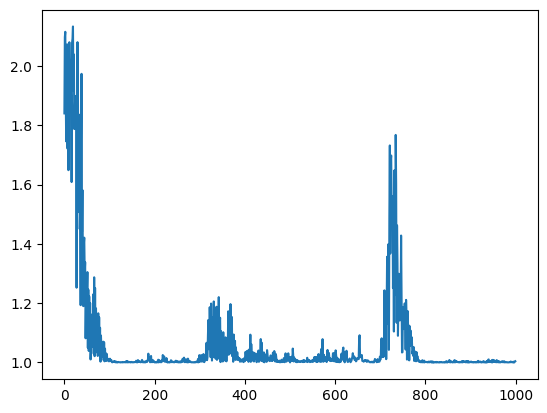

In [7]:
plt.plot(ls_loss)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Iteration 0, S: 0.1771603524684906, S_ratio: 0.09528511017560959
Iteration 10, S: 4.804889678955078, S_ratio: 0.2992611229419708
Iteration 20, S: 14.8523588180542, S_ratio: 0.44008901715278625
Iteration 30, S: 22.485631942749023, S_ratio: 0.44769489765167236
Iteration 40, S: 41.88421630859375, S_ratio: 0.44293710589408875
Iteration 50, S: 39.7141227722168, S_ratio: 0.4251490831375122
Iteration 60, S: 38.5183219909668, S_ratio: 0.4089394807815552
Iteration 70, S: 46.85552215576172, S_ratio: 0.39149150252342224
Iteration 80, S: 42.95549011230469, S_ratio: 0.3989877998828888
Iteration 90, S: 45.49894332885742, S_ratio: 0.3793586790561676
Iteration 100, S: 57.00135040283203, S_ratio: 0.3880499303340912
Iteration 110, S: 58.92639923095703, S_ratio: 0.3731834888458252
Iteration 120, S: 53.059261322021484, S_ratio: 0.3567238450050354
Iteration 130, S: 63.894168853759766, S_ratio: 0.3655948340892792
Iteration 140, S: 50.53754425048828, S_ratio: 0.36453479528427124
Iteration 150, S: 54.58068084

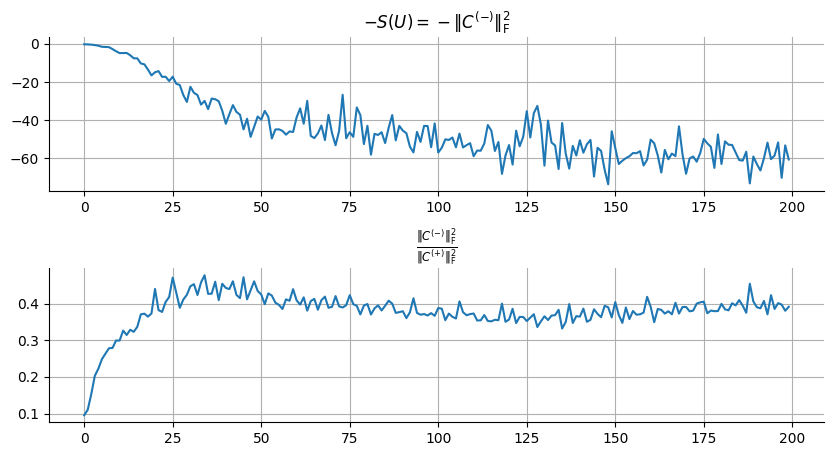

In [11]:
x, p = DDM(mu, sequence_length=50)
z, ls_h_i = model(x)

ls_X = [jnp.array(tensor.detach().numpy()) for tensor in ls_h_i]
X = jnp.stack(ls_X, axis=1).swapaxes(1,2) 
X, _ = pre_processing(X, soft_normalize=None, center=False)
K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)          
A = A.reshape(N,-1)   


kernel_function=K_X_Y_squared_exponential
d = 2
c = 30
wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=200, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

get_loss_fig(ls_loss, ls_S_ratio )

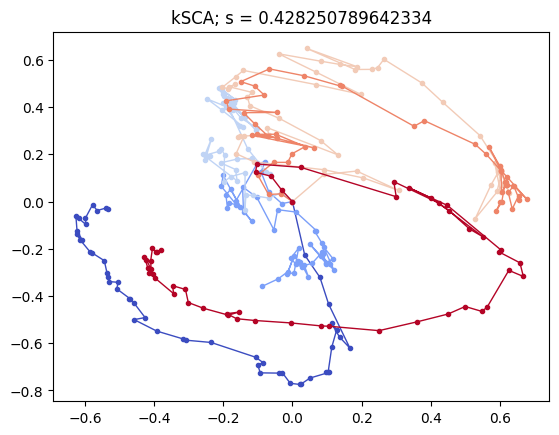

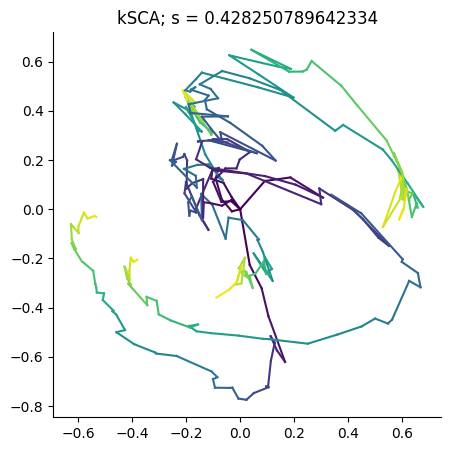

<Figure size 640x480 with 0 Axes>

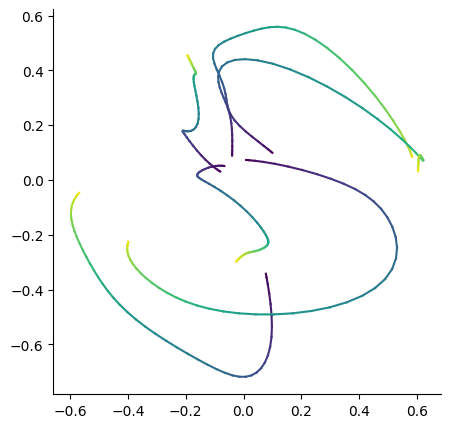

In [13]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, _, _, _  = get_alpha(params, A, X, kernel_function, d)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

fig = plt.figure()
ax = fig.add_subplot(111) #projection='3d'
cmap = plt.get_cmap('coolwarm', K)
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]

    color = cmap(k / (K - 1)) 
    ax.plot(x, y, linestyle='-', marker='.', linewidth=1, color=color)
plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')


plot_2D(Y[:,:,:])
plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

Y_smoothed = apply_gaussian_smoothing(Y, sigma=4)
plt.figure()
plot_2D(Y_smoothed)